### Rainfall data 
First part is repretition of the drought analysis but will be shown for completeness

In [1]:
%matplotlib inline 
import glob
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
from datetime import timedelta
import scipy.stats as stats
import os

# plotting
from shapely.geometry import Polygon
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium


path = os.getcwd()
home_path = os.path.dirname(os.path.dirname(path))
gis_folder = f'{home_path}\\QGIS project'

easily read all text data files  with:

In [2]:
rainfall = pd.DataFrame()
# Black_volta = -2.75E_9.50N
# Lake_Volta 0.0E_6.5N
# Mouhoun -4.00E_12.00N
# Nakambe -2.0E_13.5N
# Oti = 0.0E_8.5N
# Penjari = 1.0E_11.0N
# Ougadougou = -1.5E_12.4N

In [3]:
glob.glob(f'{home_path}\\data\\Volta_ERA5_lat_lon\*txt')

['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data\\Volta_ERA5_lat_lon\\ichirps_20_25_-1.5E_12.4N_n.dat.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data\\Volta_ERA5_lat_lon\\ichirps_20_25_-2.0E_13.5N_n.dat.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data\\Volta_ERA5_lat_lon\\ichirps_20_25_-2.75E_9.50N_i.dat.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data\\Volta_ERA5_lat_lon\\ichirps_20_25_-4.00E_12.00N_n.dat.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Information and advice\\Volta project\\Volta-burkina-faso\\data\\Volta_ERA5_lat_lon\\ichirps_20_25_0.0E_6.5N_n.dat.txt',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1400 Inform

In [4]:
lst_dfs = []
for path in glob.glob(f'{home_path}\\data\\Volta_ERA5_lat_lon\*txt'):
    df_input = pd.read_csv(path, parse_dates = [0], delimiter = ' ', index_col=[0], skiprows=31, 
                  skipinitialspace = True, header = None, usecols=[0,1], names = ['Date','precipitation'])
    
    lst_dfs.append(df_input)

In [5]:
names_col = ['Ouagadougou','Nakambe', 'Black_Volta', 'Mouhoun','Lake_Volta', 'Oti', 'Penjari'] 
Rainfall_data = pd.concat(lst_dfs, axis = 1,  keys = names_col,ignore_index=False)
Rainfall_data.columns = Rainfall_data.columns.droplevel(level=1)

### to be used later on when combining data:

In [6]:
output = True
if output:
    Rainfall_data_msum = Rainfall_data.resample('M').sum()
    Rainfall_data_msum.to_excel(f"{home_path}\\data\\Combining data\\Monthly_sum_rainfall.xlsx")

In [7]:
loc_data = []
for file in glob.glob(f'{home_path}\\data\\Volta_ERA5_lat_lon\*txt'):
    with open(file) as fin:
        for line in fin:
            process_coords = False
            if line.strip()[:15] == "# ave_region ::":
                coords = line.strip()[15:].strip()
                process_coords = True
                
            elif line.strip()[:22] == "# interpolating points":
                coords = line.strip()[22:].strip()
                process_coords = True
            
            if process_coords:
                lon, lat = coords.split(",")
                final_coord = [[float(j) for j in lon[4:].strip().split("   ")], 
                               [float(k) for k in lat[5:].strip().split("   ")]]
                [xmin, xmax], [ymin, ymax] = final_coord
    loc_data.append(Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]))
                    

In [8]:
names = ["Ouagadougou","Nakambe", "Black_Volta","Mouhoun","Lake_Volta","Oti","Penjari"]
geo_series_locations = gpd.GeoSeries(data=loc_data)

gdf_precip = gpd.GeoDataFrame(data=names, columns=["name"],geometry=geo_series_locations)

In [9]:
mid_points = gdf_precip.geometry.centroid


In [10]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

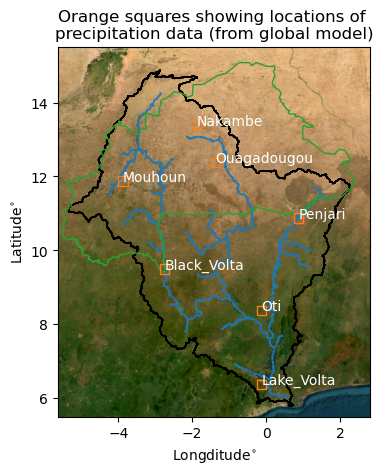

In [11]:
fig, ax = plt.subplots(1)
main_rivers.plot(ax=ax, color="C0",zorder=1)
# get the bounds for background
bounds_precip_measurements = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
gdf_precip.plot(ax=ax, facecolor="none",edgecolor="C1",zorder=10)

# add labels
mid_points = gdf_precip.geometry.centroid
for index, name in enumerate(gdf_precip.name):
    ax.annotate(name, (mid_points.iloc[index].x,mid_points.iloc[index].y),zorder=10, color="w")
# add background
with rasterio.open(get_background_map("precip_measurements", bounds_precip_measurements)) as r:
    rioshow(r, ax=ax)
    
# crop a little
ax.set_ylim((5.5,15.5))
ax.set_title("Orange squares showing locations of \nprecipitation data (from global model)")
ax.set_xlabel("Longditude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");

In [12]:
output = False
if output:
    gdf_precip.to_file(f"{home_path}\\data\\Combining data\\precipitation_data_client.geojson")

In [13]:
#making dataframe smaller to 2014-2018
Rainfall_data_2014 = Rainfall_data.loc['2014-01-01':, :]
Rainfall_data_2014.loc['2017-01-01':'2022-12-31'].head()

,Ouagadougou,Nakambe,Black_Volta,Mouhoun,Lake_Volta,Oti,Penjari
Date,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0


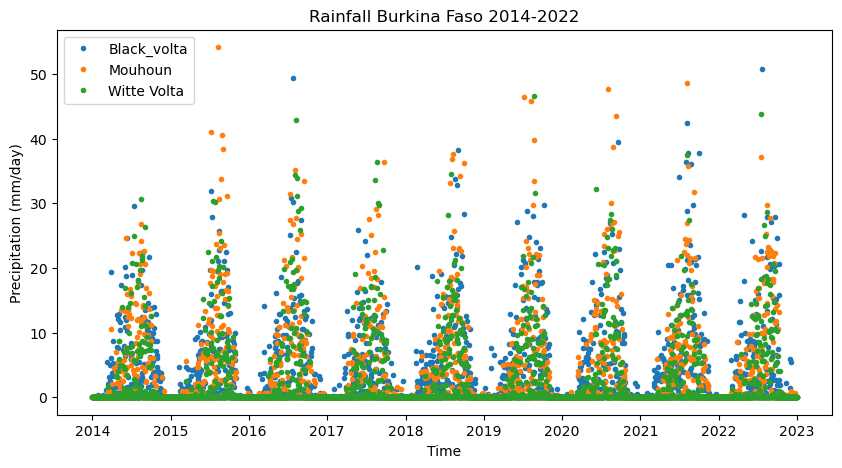

In [14]:
#plotting data from 2014 - 2022
plt.figure(figsize=(10,5))
plt.plot(Rainfall_data_2014.loc[:, 'Black_Volta'], label = 'Black_volta',marker=".",lw=0)
plt.plot(Rainfall_data_2014.loc[:, 'Mouhoun'], label = 'Mouhoun', marker='.',lw=0)
plt.plot(Rainfall_data_2014.loc[:, 'Nakambe'], label = 'Witte Volta', marker='.',lw=0)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm/day)')
plt.title('Rainfall Burkina Faso 2014-2022');
plt.legend();

Notes: 
- Rainfall has become more extreme 
- high seasonality: dry and wet season 
- High peaks and low lows 
- Maxima are around 50 to 60 mm/day

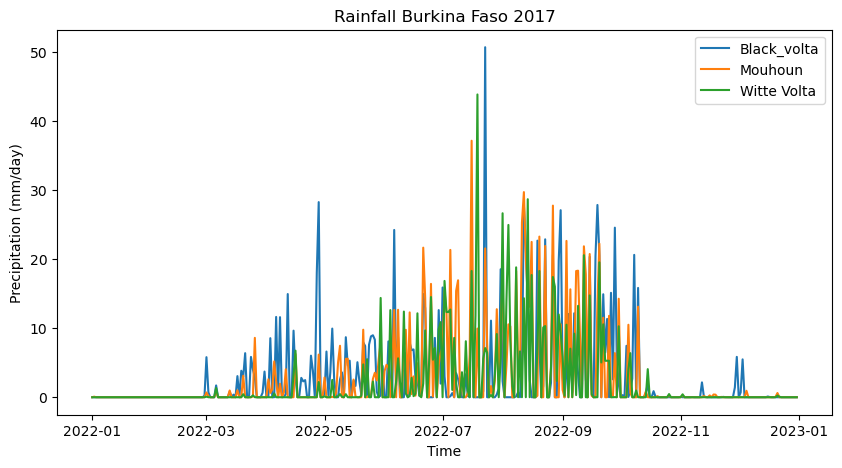

In [15]:
#plotting data in 2017
plt.figure(figsize=(10,5))
plt.plot(Rainfall_data_2014.loc['2022-01-01':'2022-12-31', 'Black_Volta'], label = 'Black_volta')
plt.plot(Rainfall_data_2014.loc['2022-01-01':'2022-12-31', 'Mouhoun'], label = 'Mouhoun')
plt.plot(Rainfall_data_2014.loc['2022-01-01':'2022-12-31', 'Nakambe'], label = 'Witte Volta')
plt.title('Rainfall Burkina Faso 2017')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm/day)')
plt.legend();

Notes: 
- Very dry season from october untill may  
- Wet season from may to october 

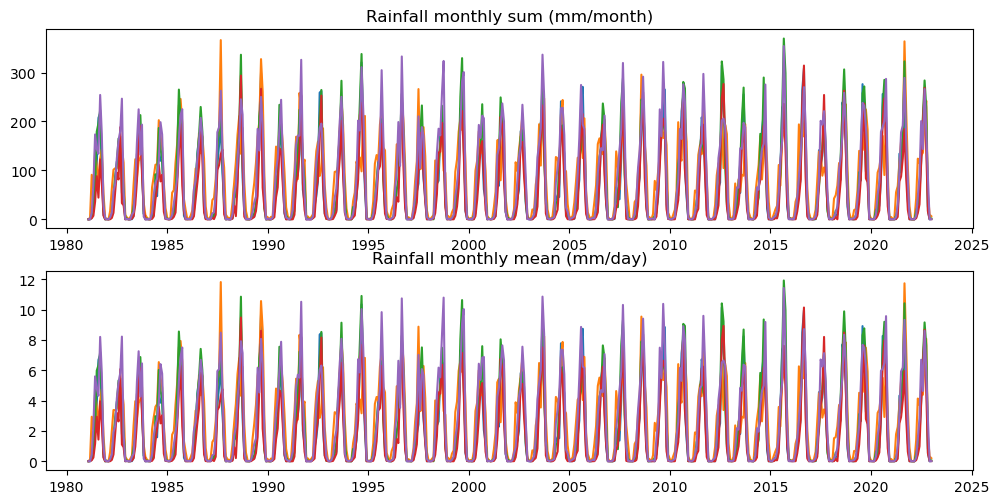

In [16]:
# sorting to only B.F 
Rainfall_sorted_BF = Rainfall_data.loc[:,['Ouagadougou','Black_Volta','Mouhoun', 'Nakambe', 'Penjari']] 
Rainfall_BF_msum = Rainfall_sorted_BF.resample('M').sum()
Rainfall_BF_mmean = Rainfall_sorted_BF.resample('M').mean()

#plotting monthly sum and mean 
fig, ax = plt.subplots(2,1,figsize= (10,5))
fig.tight_layout(h_pad=1)
ax[0].set_title('Rainfall monthly sum (mm/month)')
ax[0].plot(Rainfall_BF_msum)
ax[1].set_title('Rainfall monthly mean (mm/day)')
ax[1].plot(Rainfall_BF_mmean);

In [17]:
Rainfall_BF_msum.sum()

Ouagadougou    31142.531074
Black_Volta    42549.332879
Mouhoun        35958.471630
Nakambe        26583.642558
Penjari        41049.957017
dtype: float64

In [18]:
Rainfall_BF_msum["month"] = Rainfall_BF_msum.apply(lambda x: x.name.month, axis=1)

Growing season in Burkina Faso is between May and November

In [19]:
mask = ((Rainfall_BF_msum.month >= 5) & (Rainfall_BF_msum.month <= 11))
Rainfall_BF_msum_growing_season = Rainfall_BF_msum[mask]
Rainfall_BF_msum_growing_season

,Ouagadougou,Black_Volta,Mouhoun,Nakambe,Penjari,month
Date,,,,,,
1981-05-31,78.591566,140.261632,77.489709,35.860808,173.526988,5
1981-06-30,112.519176,107.978451,179.285071,88.180126,143.640896,6
1981-07-31,207.323537,78.178869,196.273572,44.308429,134.048451,7
1981-08-31,216.916640,124.400695,223.085272,122.409677,254.216096,8
1981-09-30,95.860457,142.819855,129.306107,74.593623,174.523889,9
...,...,...,...,...,...,...
2022-07-31,198.012473,136.009999,209.163020,189.988094,143.766882,7
2022-08-31,254.193568,197.515479,283.810280,268.714974,266.400101,8
2022-09-30,195.986965,242.311991,229.312312,143.299004,180.332295,9


Text(0.5, 1.0, 'Monthly sums of rainfall in the growing season for the Black Volta')

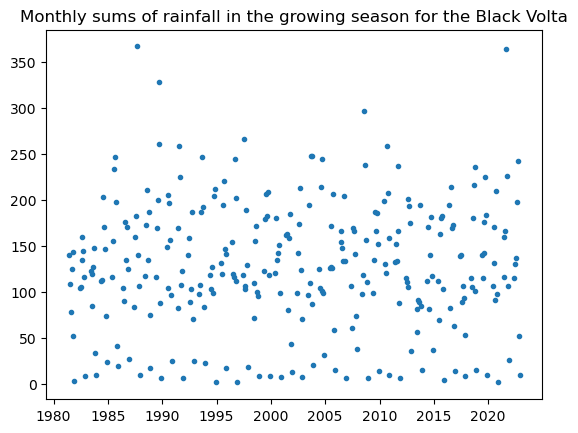

In [20]:
fig, ax = plt.subplots(1)
ax.plot(Rainfall_BF_msum_growing_season.index,Rainfall_BF_msum_growing_season["Black_Volta"],marker=".",lw=0)
ax.set_title("Monthly sums of rainfall in the growing season for the Black Volta")

# Yearly

In [21]:
# resample yearly
Rainfall_BF_ysum = Rainfall_sorted_BF.resample('Y').sum()
Rainfall_BF_ymean = Rainfall_sorted_BF.resample('Y').mean()
Rainfall_BF_ysum.head(5)

,Ouagadougou,Black_Volta,Mouhoun,Nakambe,Penjari
Date,,,,,
1981-12-31,754.847222,806.372730,847.056155,382.767435,992.835201
1982-12-31,611.447872,956.491056,728.852786,499.778791,917.659482
1983-12-31,628.151424,732.098916,723.026033,579.453776,808.718699
1984-12-31,560.948264,997.025082,701.638042,407.425785,782.821328
1985-12-31,649.428715,1124.828382,823.212610,511.587376,817.543045


Notes: 
- rainfall sum is extremely high 
- monthly mean is also high, but seems less extreme 

### Analysis of water suply from precipitation

In [22]:
df_yearly_means = pd.DataFrame(data=Rainfall_BF_ysum.mean(),columns=["P"])
# df_yearly_means.index = df_yearly_means.apply(lambda x: x.name[0], axis=1)
df_yearly_means

,P
Ouagadougou,741.488835
Black_Volta,1013.079354
Mouhoun,856.154086
Nakambe,632.943870
Penjari,977.379929


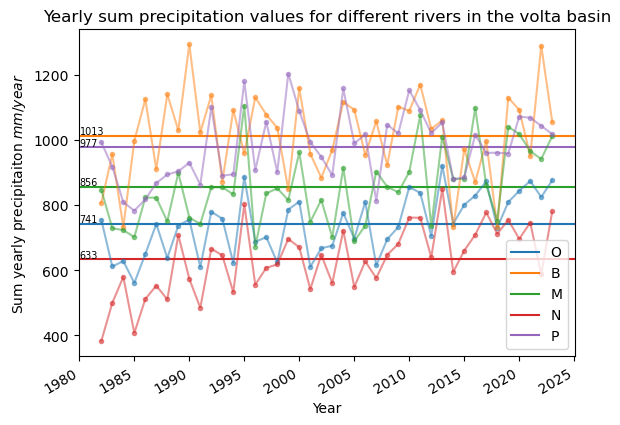

In [23]:
fig, ax = plt.subplots(1)
for index, row in enumerate(df_yearly_means.iterrows()):
    ax.axhline(row[1].P,label=row[0][0],color=f"C{index}")
    ax.annotate(f'{row[1].P:.0f}',(3660,row[1].P+5),fontsize="x-small")
ax.legend()   
Rainfall_BF_ysum.plot(ax=ax,legend=False,alpha=0.5,marker='.')

ax.set_ylabel("Sum yearly precipitaiton $mm/year$")
ax.set_xlabel("Year")
ax.set_title("Yearly sum precipitation values for different rivers in the volta basin");

In [24]:
df_yearly_means

,P
Ouagadougou,741.488835
Black_Volta,1013.079354
Mouhoun,856.154086
Nakambe,632.943870
Penjari,977.379929


In [25]:
gdf_precip

,name,geometry
0,Ouagadougou,"POLYGON ((-1.50000 12.25000, -1.25000 12.25000..."
1,Nakambe,"POLYGON ((-2.00000 13.25000, -1.75000 13.25000..."
2,Black_Volta,"POLYGON ((-2.87500 9.37500, -2.62500 9.37500, ..."
3,Mouhoun,"POLYGON ((-4.00000 11.75000, -3.75000 11.75000..."
4,Lake_Volta,"POLYGON ((-0.25000 6.25000, 0.00000 6.25000, 0..."
5,Oti,"POLYGON ((-0.25000 8.25000, 0.00000 8.25000, 0..."
6,Penjari,"POLYGON ((0.75000 10.75000, 1.00000 10.75000, ..."


In [26]:
df_yearly_means

,P
Ouagadougou,741.488835
Black_Volta,1013.079354
Mouhoun,856.154086
Nakambe,632.943870
Penjari,977.379929


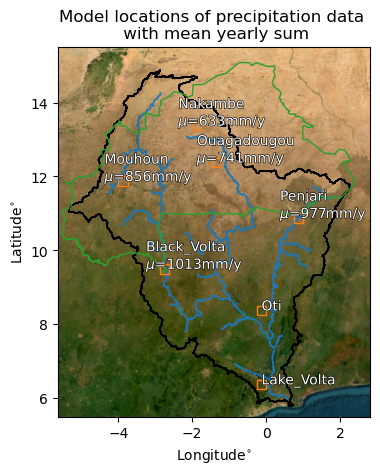

In [27]:
fig, ax = plt.subplots(1)
main_rivers.plot(ax=ax, color="C0",zorder=1)
# get the bounds for backgrounda
bounds_precip_measurements = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])

country_outline.plot(ax=ax, facecolor="none", edgecolor="C2",zorder=6)
volta_outline.plot(ax=ax,edgecolor="k", facecolor='none')
gdf_precip.plot(ax=ax, facecolor="none",edgecolor="C1",zorder=10)

# add labels
mid_points = gdf_precip.geometry.centroid
for index, name in enumerate(gdf_precip.name):
    if name in df_yearly_means.index:
        ax.annotate(f"{name} \n$\mu$={df_yearly_means.loc[name,'P']:.0f}mm/y" , 
                    (mid_points.iloc[index].x-0.5,mid_points.iloc[index].y),zorder=10, color="w",
                     path_effects=[matplotlib.patheffects.withStroke(linewidth=0.85, foreground="k")],
                     fontsize=10)
    else:
        ax.annotate(name, (mid_points.iloc[index].x,mid_points.iloc[index].y),zorder=10, color="w",
                   path_effects=[matplotlib.patheffects.withStroke(linewidth=0.85, foreground="k")])
# add background
with rasterio.open(get_background_map("precip_measurements", bounds_precip_measurements)) as r:
    rioshow(r, ax=ax)

# crop a little
ax.set_ylim((5.5,15.5))
ax.set_title("Model locations of precipitation data \n with mean yearly sum")
ax.set_xlabel("Longitude$^{\circ}$");
ax.set_ylabel("Latitude$^{\circ}$");

# OLD